In [2]:
import numpy as np
import pandas as pd
import os

import sklearn.linear_model
import sklearn.pipeline
import sklearn.metrics

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle

import matplotlib
import matplotlib.pyplot as plt

from confusion_matrix import calc_confusion_matrix_for_probas_and_threshold

In [3]:
# imports training data from files
def load_train_data():
    data_dir = "data_reviews"
    x_train_df = pd.read_csv(os.path.join(data_dir, "x_train.csv"))
    y_train_df = pd.read_csv(os.path.join(data_dir, "y_train.csv"))
    return x_train_df, y_train_df

In [4]:
def split_by_website(x_N):

    N = x_N.shape[0]

    x_amazon = [(x_N[i,1], i) for i in range(N) if x_N[i,0] == "amazon"]
    x_imdb = [(x_N[i,1], i) for i in range(N) if x_N[i,0] == "imdb"]
    x_yelp = [(x_N[i,1], i) for i in range(N) if x_N[i,0] == "yelp"]
    
    return x_amazon, x_imdb, x_yelp

In [5]:
def load_test_data():
    data_dir = "data_reviews"
    x_test_df = pd.read_csv(os.path.join(data_dir, "x_test.csv"))
    return x_test_df

In [6]:
def print_word_freq(x_train_N):
    # min_df sets sets a minimum number of times a given token needs to be
    # included in a text entry to be a part of the vector
    vectorizer = CountVectorizer(min_df=4, binary=False)
    x_vec_N = vectorizer.fit_transform(x_train_N)

    dense_arr = x_vec_N.toarray()

    freq = [
        (term, np.sum(dense_arr[:, index]))
        for term, index in list(vectorizer.vocabulary_.items())
    ]

    for term, count in sorted(freq, key=lambda x: x[1], reverse=True):
        print(f"{term} -- {count}")

In [7]:
# pipeline for BoW representation + logistic regression classifier
def make_bow_classifier_pipeline(min_df=1, max_df=1.0, C=1.0):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
            # turn data into BoW feature representation
            (
                "bow_feature_extractor",
                CountVectorizer(min_df=min_df, max_df=max_df, ngram_range=(1, 1)),
            ),
            # Given features construct the classifier (w/ hyperparam selection)
            (
                "classifier",
                sklearn.linear_model.LogisticRegression(C=C, max_iter=100000),
            ),
        ]
    )

    return pipeline

In [8]:
def make_hyperparam_grid():

    hyperparam_grid = {}

    hyperparam_grid["bow_feature_extractor__min_df"] = [1, 2, 4, 8, 16, 32]
    hyperparam_grid["bow_feature_extractor__max_df"] = [1.0, 0.5, 0.25, 0.15]
    hyperparam_grid["classifier__C"] = np.logspace(-6, 6, 13)

    return hyperparam_grid

# Import data and train model using GridSearch

In [9]:
x_train_df, y_train_df = load_train_data()

x_test_df = load_test_data()

In [10]:
# getting rid of company label
x_train_N = x_train_df.to_numpy()[:, 1]
y_train_N = y_train_df.to_numpy()[:, 0]

x_test_N = x_test_df.to_numpy()[:, 1]

# shuffle dataset
x_train_N, y_train_N = shuffle(x_train_N, y_train_N, random_state=2)

In [11]:
pipeline = make_bow_classifier_pipeline()
hyperparam_grid = make_hyperparam_grid()

grid_searcher = sklearn.model_selection.GridSearchCV(
    pipeline,
    hyperparam_grid,
    cv=10,
    scoring="roc_auc"
)

grid_searcher.fit(x_train_N, y_train_N)

best_model = grid_searcher.best_estimator_
best_params = grid_searcher.best_params_
best_score = grid_searcher.best_score_

yhat_proba_test_N = best_model.predict_proba(x_test_N)

np.savetxt("yproba1_test.txt", yhat_proba_test_N[:,1])

print(f"best score: {best_score}; best params:", best_params)

best score: 0.8888958333333333; best params: {'bow_feature_extractor__max_df': 0.15, 'bow_feature_extractor__min_df': 1, 'classifier__C': 1.0}


In [12]:

# fold 1 values
x_valid = x_train_N[:240]
y_valid = y_train_N[:240]

x_train = x_train_N[240:]
y_train = y_train_N[240:]

c_values = np.logspace(-8, 8, 17)

models = []
train_error = []
valid_error = []

# train_bce = []
# valid_bce = []



for c in c_values:
    curr_pipeline = make_bow_classifier_pipeline(C=c)
    curr_pipeline.fit(x_train, y_train)

    models.append(curr_pipeline)

    yhat_proba_train = curr_pipeline.predict_proba(x_train)[:,1]
    yhat_proba_valid = curr_pipeline.predict_proba(x_valid)[:,1]

    train_error.append(sklearn.metrics.zero_one_loss(y_train, yhat_proba_train >= 0.5))
    valid_error.append(sklearn.metrics.zero_one_loss(y_valid, yhat_proba_valid >= 0.5))

    # train_bce.append(sklearn.metrics.log_loss(y_train, yhat_proba_train >= 0.5))
    # valid_bce.append(sklearn.metrics.log_loss(y_valid, yhat_proba_valid >= 0.5))




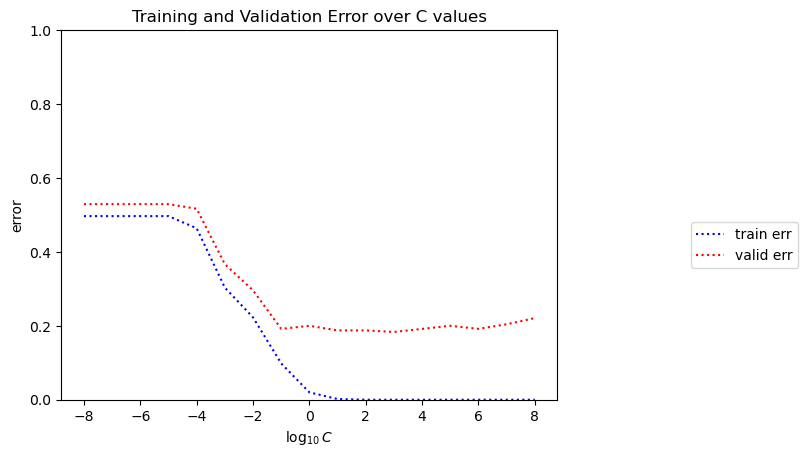

In [13]:
# plt.plot(np.log10(c_values), train_bce, 'bs-', label='train BCE')
# plt.plot(np.log10(c_values), valid_bce, 'rs-', label='valid BCE')

plt.title("Training and Validation Error over C values");
plt.plot(np.log10(c_values), train_error, 'b:', label='train err')
plt.plot(np.log10(c_values), valid_error, 'r:', label='valid err')

plt.ylabel('error')
plt.xlabel("$\log_{10} C$");
plt.legend(bbox_to_anchor=(1.5, 0.5)) # make legend outside plot
plt.ylim([0, 1.0]);

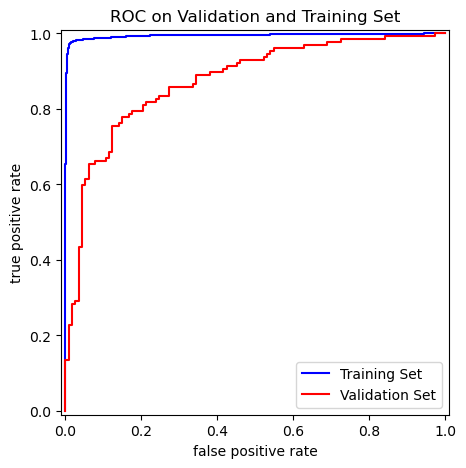

In [14]:
pipeline = make_bow_classifier_pipeline(C=1.0)

pipeline.fit(x_train, y_train)

yhat_train = pipeline.predict_proba(x_train)[:,1]
yhat_valid = pipeline.predict_proba(x_valid)[:,1]

plt.subplots(nrows=1, ncols=1, figsize=(5,5));


fpr_tr, tpr_tr, thresholds_tr = sklearn.metrics.roc_curve(y_train, yhat_train)
fpr_va, tpr_va, thresholds_va = sklearn.metrics.roc_curve(y_valid, yhat_valid)

plt.plot(fpr_tr, tpr_tr, 'b-', label='Training Set')
plt.plot(fpr_va, tpr_va, 'r-', label='Validation Set')

plt.title("ROC on Validation and Training Set");
plt.xlabel('false positive rate');
plt.ylabel('true positive rate');
plt.legend(loc='lower right');
B = 0.01
plt.xlim([0 - B, 1 + B]);
plt.ylim([0 - B, 1 + B]);


In [15]:
yhat_proba_valid = pipeline.predict_proba(x_valid)[:,1]
accuracies = [sklearn.metrics.accuracy_score(y_valid, yhat_proba_valid >= thres) for thres in thresholds_va]

max_acc_threshold = thresholds_va[accuracies.index(max(accuracies))]

calc_confusion_matrix_for_probas_and_threshold(y_valid, yhat_proba_valid, max_acc_threshold)

Predicted,0,1
True,,
0,99,14
1,31,96


In [16]:
yhat_valid = yhat_proba_valid >= max_acc_threshold

false_positive_indices = [yhat_valid[i] == 1 and y_valid[i] == 0 for i in range(len(y_valid))]
false_negative_indices = [yhat_valid[i] == 0 and y_valid[i] == 1 for i in range(len(y_valid))]

false_positives = x_valid[false_positive_indices]
false_negatives = x_valid[false_negative_indices]

print(len(false_positives))
print(len(false_negatives))

print(false_positives)
print(false_negatives)

14
31
['The cashier had no care what so ever on what I had to say it still ended up being wayyy overpriced.'
 'You can find better movies at youtube.  '
 'It failed to convey the broad sweep of landscapes that were a great part of the original.  '
 "Verizon's bills, however, are difficult to understand even though their pricing plans are simple."
 "I'll even say it again \x96 this is torture.  "
 'And the accents are absolutely abysmal!  '
 'The Heart Attack Grill in downtown Vegas is an absolutely flat-lined excuse for a restaurant.'
 'You need two hands to operate the screen.This software interface is decade old and cannot compete with new software designs.'
 "I tried talking real loud but shouting on the telephone gets old and I was still told it wasn't great."
 'Unless you\'re just out to visually "collect" all extant films of Austen\'s work, you can skip this one.  '
 'The potatoes were like rubber and you could tell they had been made up ahead of time being kept under a warmer.'


In [19]:
x_train_N, y_train_N, shuffled_indices = shuffle(x_train_N, y_train_N, np.arange(x_train_N.shape[0]), random_state=2)
valid_indices = shuffled_indices[:240]
train_indices = shuffled_indices[240:]

x_valid = x_train_N[:240]
y_valid = y_train_N[:240]

x_train = x_train_N[240:]
y_train = y_train_N[240:]

false_positive_actual_indices = valid_indices[np.where(false_positive_indices)]
false_negative_actual_indices = valid_indices[np.where(false_negative_indices)]

false_positive_sources = x_train_df.iloc[false_positive_actual_indices, 0].values
false_negative_sources = x_train_df.iloc[false_negative_actual_indices, 0].values

print("Sources of false positives:", false_positive_sources)
print("Sources of false negatives:", false_negative_sources)

Sources of false positives: ['yelp' 'imdb' 'imdb' 'amazon' 'imdb' 'imdb' 'yelp' 'amazon' 'amazon'
 'imdb' 'yelp' 'imdb' 'amazon' 'imdb']
Sources of false negatives: ['imdb' 'yelp' 'imdb' 'imdb' 'imdb' 'amazon' 'yelp' 'imdb' 'imdb' 'yelp'
 'amazon' 'imdb' 'amazon' 'amazon' 'imdb' 'imdb' 'yelp' 'yelp' 'imdb'
 'imdb' 'imdb' 'yelp' 'imdb' 'yelp' 'yelp' 'imdb' 'imdb' 'imdb' 'amazon'
 'imdb' 'yelp']


In [17]:
vectorizer = CountVectorizer(min_df=1, max_df=1.0, ngram_range=(1, 1))
vectorizer.fit_transform(x_train_N)

print(len(vectorizer.vocabulary_))

4510


# GridSearch results 

In [ ]:
grid_search_results_df = pd.DataFrame(grid_searcher.cv_results_).copy()

param_keys = ['param_bow_feature_extractor__min_df', 'param_bow_feature_extractor__max_df', 'param_classifier__C']

grid_search_results_df.sort_values(param_keys, inplace=True)
grid_search_results_df[param_keys + ['split0_test_score', 'rank_test_score']]

,param_bow_feature_extractor__min_df,param_bow_feature_extractor__max_df,param_classifier__C,split0_test_score,rank_test_score
220,1,0.5,0.1,0.845625,211
221,1,0.5,0.158489,0.854583,163
222,1,0.5,0.251189,0.860833,85
223,1,0.5,0.398107,0.866736,67
224,1,0.5,0.630957,0.870486,31
...,...,...,...,...,...
39,4,1.0,1.584893,0.855625,157
40,4,1.0,2.511886,0.851111,187
41,4,1.0,3.981072,0.845486,223
42,4,1.0,6.309573,0.837500,247


# Multi-website model approach

In [85]:
x_train_df, y_train_df = load_train_data()

x_test_df = load_test_data()

x_amazon, x_imdb, x_yelp = split_by_website(x_train_df.to_numpy())

In [86]:
amazon_text, amazon_indices = zip(*x_amazon)
imdb_text, imdb_indices = zip(*x_imdb)
yelp_text, yelp_indices = zip(*x_yelp)

amazon_text = np.asarray(list(amazon_text))
amazon_indices = np.asarray(list(amazon_indices))

imdb_text = np.asarray(list(imdb_text))
imdb_indices = np.asarray(list(imdb_indices))

yelp_text = np.asarray(list(yelp_text))
yelp_indices = np.asarray(list(yelp_indices))

y_train_N = y_train_df.to_numpy()

y_amazon = y_train_N[amazon_indices][:,0]
y_imdb = y_train_N[imdb_indices][:,0]
y_yelp = y_train_N[yelp_indices][:,0]

In [87]:
amazon_text, y_amazon = shuffle(amazon_text, y_amazon, random_state=2)
imdb_text, y_imdb = shuffle(imdb_text, y_imdb, random_state=2)
yelp_text, y_yelp = shuffle(yelp_text, y_yelp, random_state=2)

In [88]:
amazon_pipeline = make_bow_classifier_pipeline()
amazon_hyperparam_grid = make_hyperparam_grid()

amazon_grid_searcher = sklearn.model_selection.GridSearchCV(
    amazon_pipeline,
    amazon_hyperparam_grid,
    cv=10,
    scoring="roc_auc"
)

imdb_pipeline = make_bow_classifier_pipeline()
imdb_hyperparam_grid = make_hyperparam_grid()

imdb_grid_searcher = sklearn.model_selection.GridSearchCV(
    imdb_pipeline,
    imdb_hyperparam_grid,
    cv=10,
    scoring="roc_auc"
)

yelp_pipeline = make_bow_classifier_pipeline()
yelp_hyperparam_grid = make_hyperparam_grid()

yelp_grid_searcher = sklearn.model_selection.GridSearchCV(
    yelp_pipeline,
    yelp_hyperparam_grid,
    cv=10,
    scoring="roc_auc"
)

grid_searchers = [amazon_grid_searcher, imdb_grid_searcher, yelp_grid_searcher]


grid_searchers[0].fit(amazon_text, y_amazon)
grid_searchers[1].fit(imdb_text, y_imdb)
grid_searchers[2].fit(yelp_text, y_yelp)


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('bow_feature_extractor',
                                        CountVectorizer(min_df=2)),
                                       ('classifier',
                                        LogisticRegression(max_iter=100000))]),
             param_grid={'bow_feature_extractor__max_df': [1.0, 0.9, 0.8, 0.7,
                                                           0.6, 0.5, 0.4, 0.3],
                         'bow_feature_extractor__min_df': [1, 2, 3, 4, 8],
                         'classifier__C': array([1.00000000e-02, 1.62377674e-02, 2.63665090e-02, 4.28133240e-02,
       6.95192796e-02, 1.12883789e-01, 1.83298071e-01, 2.97635144e-01,
       4.83293024e-01, 7.84759970e-01, 1.27427499e+00, 2.06913808e+00,
       3.35981829e+00, 5.45559478e+00, 8.85866790e+00, 1.43844989e+01,
       2.33572147e+01, 3.79269019e+01, 6.15848211e+01, 1.00000000e+02])},
             scoring='roc_auc')

In [89]:
best_models = [grid_searchers[i].best_estimator_ for i in range(3)]

x_test_amazon, x_test_imdb, x_test_yelp = split_by_website(x_test_df.to_numpy())

x_test_amazon_text, _ = zip(*x_test_amazon)
x_test_imdb_text, _ = zip(*x_test_imdb)
x_test_yelp_text, _ = zip(*x_test_yelp)

x_test_amazon_text = np.asarray(x_test_amazon_text)
x_test_imdb_text = np.asarray(x_test_imdb_text)
x_test_yelp_text = np.asarray(x_test_yelp_text)

In [90]:
yhat_amazon = best_models[0].predict_proba(x_test_amazon_text)[:,1]
yhat_imdb = best_models[1].predict_proba(x_test_imdb_text)[:,1]
yhat_yelp = best_models[2].predict_proba(x_test_yelp_text)[:,1]

yhat_test_N = np.concatenate((yhat_amazon, yhat_imdb, yhat_yelp))

np.savetxt("yproba1_test.txt", yhat_test_N)

for searcher in grid_searchers:
    best_params = searcher.best_params_
    best_score = searcher.best_score_

    print(f"best score: {best_score}; best params:", best_params)
    



best score: 0.89925; best params: {'bow_feature_extractor__max_df': 1.0, 'bow_feature_extractor__min_df': 1, 'classifier__C': 37.92690190732246}
best score: 0.8520000000000001; best params: {'bow_feature_extractor__max_df': 0.3, 'bow_feature_extractor__min_df': 1, 'classifier__C': 3.359818286283781}
best score: 0.89175; best params: {'bow_feature_extractor__max_df': 0.3, 'bow_feature_extractor__min_df': 1, 'classifier__C': 3.359818286283781}
